# Mini Proyecto II
**Fundamentos de Análisis y Cálculo Numérico**  

**Integrantes**:  
- Luz Amelia Ibarguen – 2380404  
- Katherine Lopez Unas – 2380339  
- Andres Mauricio Peña Lopez – 2380335

**Profesor**: Ing. Mateo Echeverry Correa  
**Semestre**: 2025-II  

*Predicción de clasificación de maravillas del mundo Red Neuronal Artificial*

In [1]:
# PASO 1. DESCARGA DEL DATASET DESDE GOOGLE DRIVE 

import os
import zipfile
import gdown
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

ZIP_PATH = "Maravillas del mundo.zip"
BASE_DIR = "./wonders_dataset"

# Si el dataset no existe localmente, lo descargamos
if not os.path.exists(BASE_DIR):
    print("Descargando dataset desde Google Drive...")
    gdown.download(
        url="https://drive.google.com/uc?id=1QXQA1HLq7GNIoKgi7MCTymht0bsdmDGk",
        output=ZIP_PATH,
        quiet=False
    )
    
    print("Descomprimiendo...")
    os.makedirs(BASE_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)
    
    print("Eliminando ZIP...")
    os.remove(ZIP_PATH)

print(f"Dataset listo en: {BASE_DIR}")

Dataset listo en: ./wonders_dataset


In [2]:
# PASO 2: CARGA Y LIMPIEZA DEL DATASET

# Rutas - os.path.join => arma rutas de archivos 
RUTA_CSV = os.path.join(BASE_DIR, "wonders_of_world_images.csv")
CARPETA_IMAGENES = os.path.join(BASE_DIR, "Wonders of World", "Wonders of World")

# Carga del csv, conteo de filas del DataFrame y el total de clases unicas diferentes
df = pd.read_csv(RUTA_CSV)
print(f"CSV: {len(df)} imágenes, {df['folder_name'].nunique()} clases únicas")

# Construir rutas absolutas para las imagenes
# dentro de el csv existen 2 columnas (nombre_carpeta, nombre_imagen), el objetivo es unir las 2 rutas en una sola
# finalmente esta ruta es guardada en una nueva columna ('ruta_imagen')
df['ruta_imagen'] = df.apply(lambda row: os.path.join(CARPETA_IMAGENES, row['folder_name'], row['filename']), axis=1)

# --- Verificar y corregir imágenes (¡clave para evitar 6% de accuracy!) ---
print("Convirtiendo imágenes a RGB y eliminando corruptas...")
valid_rows = []                                                      # lista para almacenar imagenes
for idx, row in df.iterrows():                                       # recorre cada fila del dataframe
    path = row['ruta_imagen']                                         # obtiene la ruta completa de la imagen (de la nueva columna)
    try:
        with Image.open(path) as img:                                # si la imagen se puede abrir entonces esta sana
            rgb_img = img.convert('RGB')                             # Forzar conversión a RGB (soluciona modo 'P', 'L', etc.)
            rgb_img.save(path, quality=95)                           # Sobrescribe en formato RGB (la guarda de nuevo), quiality=95 es para la calidad
        valid_rows.append(True)                                      
    except Exception as e:
        print(f"⚠️ Imagen corrupta eliminada: {path} → {e}")        # la imagen esta dañada o no se puede abrir
        valid_rows.append(False)

# df[valid_rows] solo toma los valores True, por tanto se eliminan las imagenes corruptas del dataset y se reinician los indices (0,1,2,3...)
df = df[valid_rows].reset_index(drop=True)

print(f"✅ Dataset limpio: {len(df)} imágenes válidas.")

CSV: 3846 imágenes, 12 clases únicas
Convirtiendo imágenes a RGB y eliminando corruptas...
⚠️ Imagen corrupta eliminada: ./wonders_dataset\Wonders of World\Wonders of World\pyramids_of_giza\f444081e5f.jpg → cannot identify image file './wonders_dataset\\Wonders of World\\Wonders of World\\pyramids_of_giza\\f444081e5f.jpg'
✅ Dataset limpio: 3845 imágenes válidas.



 📊 Conteo por clase: 
 folder_name
roman_colosseum          394
machu_pichu              393
great_wall_of_china      392
eiffel_tower             391
burj_khalifa             390
pyramids_of_giza         371
chichen_itza             340
christ_the_reedemer      323
venezuela_angel_falls    251
statue_of_liberty        238
stonehenge               204
taj_mahal                158


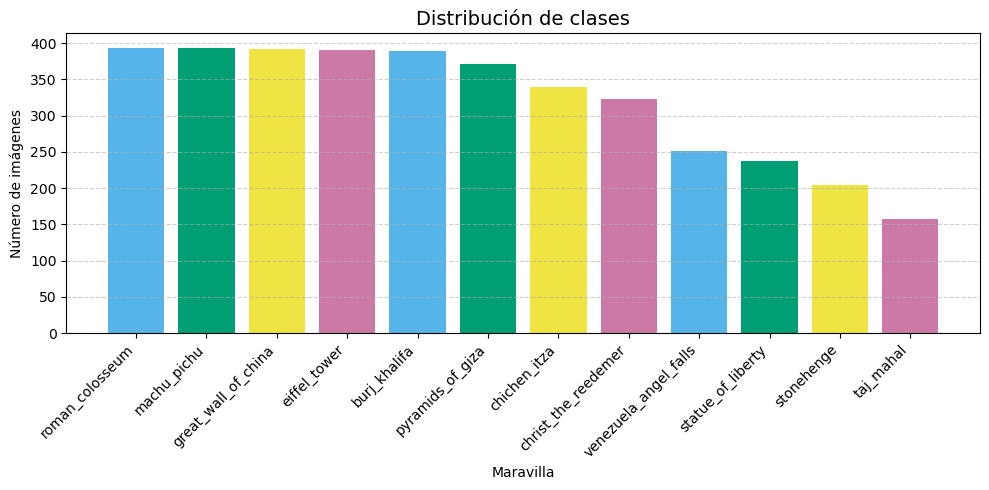


 Dimensiones promedio (muestra de 200 imágenes)...
  → Ancho promedio: 568 px
  → Alto promedio:  398 px

🖼️ Muestras aleatorias por clase...


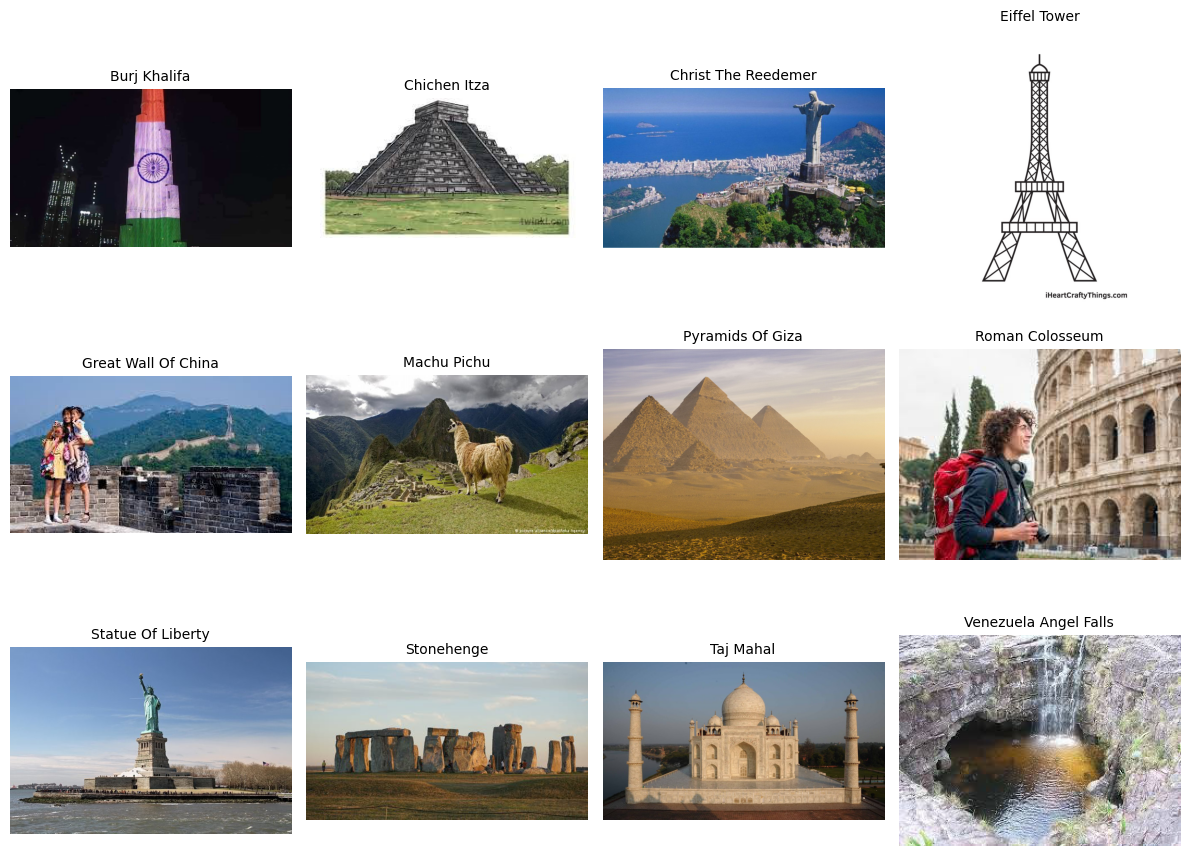

In [3]:
# PASO 3: ANÁLISIS EXPLORATORIO DE DATOS (EDA)

# --- Estadísticas descriptivas ---
conteo_clases = df['folder_name'].value_counts() # cantidad de imagenes por clase 
print("\n 📊 Conteo por clase: \n", conteo_clases.to_string())

# Gráfico de distribución
colors = ['#56B4E9', '#009E73', '#F0E442', '#CC79A7'] * 4                                 # Repetir para 12 clases
plt.figure(figsize=(10, 5))
bars = plt.bar(conteo_clases.index, conteo_clases.values, color=colors[:len(conteo_clases)]) # Dibujar la grafica de barras
plt.title("Distribución de clases", fontsize=14)
plt.xlabel("Maravilla")
plt.ylabel("Número de imágenes")                                                          
plt.xticks(rotation=45, ha='right')                                           # rota las etiquetas del eje x 45 grados
plt.grid(axis='y', linestyle='--', alpha=0.6)                                 # agrega lineas punteadas azules
plt.tight_layout()                                                            # evita que el texto se corte
plt.show()

# --- Dimensiones promedio (muestra de 200 imágenes) ---
print("\n Dimensiones promedio (muestra de 200 imágenes)...")
dimensiones = []                                                              # almacena la tupla del tamaño de cada imagen
for path in df['ruta_imagen'].sample(min(200, len(df)), random_state=42):     # recorre una muestra aleatoria de 200 imagenes
    with Image.open(path) as img:                                             # abre la imagen usando pillow
        dimensiones.append(img.size)                                          # se guarda la tupla de las dimensiones en la lista
anchos, alturas = zip(*dimensiones)                                           # crea dos listas una para anchos y otra para alturas
print(f"  → Ancho promedio: {np.mean(anchos):.0f} px")
print(f"  → Alto promedio:  {np.mean(alturas):.0f} px")

# --- Muestras aleatorias por clase ---
print("\n🖼️ Muestras aleatorias por clase...")
fig, axes = plt.subplots(3, 4, figsize=(12, 9))                               # se crea una figura de 12 espacios donde se muestra una figura por clase           
nombres_clases = sorted(df['folder_name'].unique())                              # 12 nombres de las clases ordenadas alfabeticamente
for i, cls in enumerate(nombres_clases):                                         # iterar lista de clases, y obtener el indice de cada elemento
    ax = axes[i//4, i%4]                                                      # selecciona el eje correspondiente de la matriz 3x4
    sample_img = df[df['folder_name'] == cls]['ruta_imagen'].sample(1).iloc[0] # selecciona una imagen aleatoria de la clase
    img = Image.open(sample_img)                                              # abrir la imagen
    ax.imshow(img)                                                            # toma la imagen dentro del eje correspondiente
    ax.set_title(cls.replace('_', ' ').title(), fontsize=10)                  # titulo de la clase 
    ax.axis('off')                                                            # ocultar lineas, bordes y numeros del subplot
plt.tight_layout()                                                            # ajuste de elementos para que no se sobrepongan
plt.show()

In [4]:
# PASO 4: DATA AUGMENTATION Y CARGA OPTIMIZADA 

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- Codificar etiquetas ---
nombres_clases = sorted(df['folder_name'].unique())               # extraer y ordenar los nombres alfabeticamente de las clases   
clase_a_indice = {cls: i for i, cls in enumerate(nombres_clases)}   # crea un diccionario con el nombre de la clase y un indice
df['label'] = df['folder_name'].map(clase_a_indice)              # crea una columna label y remplaza todas las clases con cada indice correspondiente

# --- Dividir train/val (80/20, estratificado) ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# --- Función de carga + augmentación ligera ---
def cargar_y_preprocesar(path, label, augment=False):
    image = tf.io.read_file(path)                                    # lee la imagen desde el archivo (binario)
    try:
        image = tf.io.decode_jpeg(image, channels=3)                 # Intenta decodificar como jpeg primero (más rápido)
    except tf.errors.InvalidArgumentError:
        image = tf.io.decode_png(image, channels=3)                  # si no es jpeg lo intenta como png
    image = tf.image.resize(image, [128, 128])                       # redimensiona las imagenes a un mismo tamaño
    image = tf.cast(image, tf.float32) / 255.0                       # convierte la imagen en valores entre 0 y 1
    
    if augment:
        image = tf.image.random_flip_left_right(image)               # voltea la imagen horizontalmente
        image = tf.image.random_brightness(image, 0.1)               # cambia ligeramente el brillo 
        image = tf.image.random_contrast(image, 0.8, 1.2)            # modifica el contraste 
        image = tf.image.random_saturation(image, 0.8, 1.2)          # cambia cuanto color tiene 
        image = tf.image.random_hue(image, 0.1)                      # ajusta el tono general del color 
    
    image.set_shape([128, 128, 3])                                   # asegurarse de que la forma final sea [128, 128, 3]
    return image, to_categorical(label, num_classes=len(nombres_clases)) # convertir la etiqueta a one hot

# --- Crear tf.data ---
BATCH_SIZE = 64 

train_ds = tf.data.Dataset.from_tensor_slices((train_df['ruta_imagen'].values, train_df['label'].values))   # crear el dataset de entrenamiento
train_ds = train_ds.map(lambda x, y: cargar_y_preprocesar(x, y, augment=True),                              # aplicar la funcion de preprocesamiento
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)                      # preparar el dataset para entrenamiento

val_ds = tf.data.Dataset.from_tensor_slices((val_df['ruta_imagen'].values, val_df['label'].values))         # crear el dataset de validacion
val_ds = val_ds.map(cargar_y_preprocesar, num_parallel_calls=tf.data.AUTOTUNE)                              # aplicar la funcion de preprocesamiento sin augment
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)                                        # optimizar la validacion

print(f"✅ Datasets listos: {len(train_df)} train / {len(val_df)} val imágenes.")

✅ Datasets listos: 3076 train / 769 val imágenes.


In [5]:
# PASO 5: ARQUITECTURA CNN 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # capas convolucionales (extrae caracteristicas y patrones visuales de las imagenes)
    # padding permite que la imagen no se vuelva mas pequeña, agrega bordes alrededor de la imagen
    # MaxPooling2D sirve para reducir la imagen a la mitad y permitir de que el modelo aprenda mejor
    
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3), padding='same'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu', padding='same'),  
    MaxPooling2D(2,2),
    
    Flatten(), # aplana la imagen de 2D a 1 vector de 1D
    Dense(256, activation='relu'),  
    Dropout(0.5),
    Dense(12, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,060 (17.49 MB)

 Trainable params: 4,586,060 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# PASO 6: ENTRENAMIENTO (con EarlyStopping y ReduceLROnPlateau)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Detiene el entrenamiento automáticamente cuando el modelo deja de mejorar 8 epocas
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),

    # Si el modelo deja de mejorar, baja el learning rate automáticamente a la mitad, tras 4 epocas
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-7),

    # Guarda automáticamente el mejor modelo durante el entrenamiento
    ModelCheckpoint('mejor_modelo_wonders.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1108 - loss: 2.5117

49/49 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.1583 - loss: 2.4017 - val_accuracy: 0.2432 - val_loss: 2.1607 - learning_rate: 0.0010
Epoch 2/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2423 - loss: 2.1481

49/49 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.2656 - loss: 2.0932 - val_accuracy: 0.4304 - val_loss: 1.8005 - learning_rate: 0.0010
Epoch 3/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3799 - loss: 1.8454

49/49 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.3947 - loss: 1.8125 - val_accuracy: 0.4902 - val_loss: 1.4984 - learning_rate: 0.0010
Epoch 4/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4283 - loss: 1.6833

49/49 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.4473 - loss: 1.6162 - val_accuracy: 0.5527 - val_loss: 1.3604 - learning_rate: 0.0010
Epoch 5/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5335 - loss: 1.4026

49/49 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5289 - loss: 1.4014 - val_accuracy: 0.5969 - val_loss: 1.2156 - learning_rate: 0.0010
Epoch 6/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5730 - loss: 1.2761

49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5790 - loss: 1.2604 - val_accuracy: 0.6398 - val_loss: 1.0843 - learning_rate: 0.0010
Epoch 7/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6103 - loss: 1.1040

49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6330 - loss: 1.0744 - val_accuracy: 0.6567 - val_loss: 1.0513 - learning_rate: 0.0010
Epoch 8/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6836 - loss: 0.9775

49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6902 - loss: 0.9382 - val_accuracy: 0.6697 - val_loss: 1.0443 - learning_rate: 0.0010
Epoch 9/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7222 - loss: 0.8449

49/49 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7155 - loss: 0.8592 - val_accuracy: 0.6814 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 10/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7754 - loss: 0.6634

49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7731 - loss: 0.6729 - val_accuracy: 0.7477 - val_loss: 0.8772 - learning_rate: 0.0010
Epoch 11/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7971 - loss: 0.5804

49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8036 - loss: 0.5629 - val_accuracy: 0.7529 - val_loss: 0.8500 - learning_rate: 0.0010
Epoch 12/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8306 - loss: 0.5024 - val_accuracy: 0.7386 - val_loss: 0.8522 - learning_rate: 0.0010
Epoch 13/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8605 - loss: 0.4168 - val_accuracy: 0.7412 - val_loss: 0.9264 - learning_rate: 0.0010
Epoch 14/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8755 - loss: 0.3614 - val_accuracy: 0.7438 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 15/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8924 - loss: 0.3063 - val_accuracy: 0.7477 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 16/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9223 - loss: 0.2535

49/49 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9301 - loss: 0.2234 - val_accuracy: 0.7789 - val_loss: 0.9544 - learning_rate: 5.0000e-04
Epoch 17/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9317 - loss: 0.1775

49/49 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9415 - loss: 0.1649 - val_accuracy: 0.7893 - val_loss: 0.9907 - learning_rate: 5.0000e-04
Epoch 18/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9554 - loss: 0.1398

49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9525 - loss: 0.1479 - val_accuracy: 0.7945 - val_loss: 0.9399 - learning_rate: 5.0000e-04
Epoch 19/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9600 - loss: 0.1252 - val_accuracy: 0.7867 - val_loss: 1.0750 - learning_rate: 5.0000e-04
Epoch 20/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9645 - loss: 0.1017

49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9639 - loss: 0.1029 - val_accuracy: 0.7958 - val_loss: 1.1119 - learning_rate: 5.0000e-04
Epoch 21/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9655 - loss: 0.0977 - val_accuracy: 0.7867 - val_loss: 1.1759 - learning_rate: 5.0000e-04
Epoch 22/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9640 - loss: 0.1089

49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9681 - loss: 0.0982 - val_accuracy: 0.7997 - val_loss: 1.1553 - learning_rate: 5.0000e-04
Epoch 23/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9724 - loss: 0.0888 - val_accuracy: 0.7815 - val_loss: 1.1527 - learning_rate: 5.0000e-04
Epoch 24/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9727 - loss: 0.0785 - val_accuracy: 0.7958 - val_loss: 1.1856 - learning_rate: 5.0000e-04
Epoch 25/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9716 - loss: 0.0820

49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9688 - loss: 0.0915 - val_accuracy: 0.8049 - val_loss: 1.1653 - learning_rate: 5.0000e-04
Epoch 26/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9756 - loss: 0.0720 - val_accuracy: 0.7750 - val_loss: 1.3338 - learning_rate: 5.0000e-04
Epoch 27/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9717 - loss: 0.0824 - val_accuracy: 0.7984 - val_loss: 1.2296 - learning_rate: 5.0000e-04
Epoch 28/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9776 - loss: 0.0728 - val_accuracy: 0.7828 - val_loss: 1.3131 - learning_rate: 5.0000e-04
Epoch 29/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9714 - loss: 0.0846 - val_accuracy: 0.7945 - val_loss: 1.1718 - learning_rate: 5.0000e-04
Epoch 30/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9811 - loss: 0.0553 - val_accuracy: 0.8023 - val_loss: 1.1864 - learning_rate: 2.5000e-04
Epoch 31/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9802 - loss

49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9798 - loss: 0.0528 - val_accuracy: 0.8062 - val_loss: 1.2632 - learning_rate: 2.5000e-04
Epoch 33/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9828 - loss: 0.0531 - val_accuracy: 0.8049 - val_loss: 1.2934 - learning_rate: 2.5000e-04
Epoch 34/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9883 - loss: 0.0390 - val_accuracy: 0.7997 - val_loss: 1.3330 - learning_rate: 2.5000e-04
Epoch 35/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9894 - loss: 0.0382

49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9867 - loss: 0.0413 - val_accuracy: 0.8075 - val_loss: 1.2726 - learning_rate: 2.5000e-04
Epoch 36/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9858 - loss: 0.0391

49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9834 - loss: 0.0458 - val_accuracy: 0.8088 - val_loss: 1.2868 - learning_rate: 2.5000e-04
Epoch 37/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9886 - loss: 0.0387 - val_accuracy: 0.8062 - val_loss: 1.3486 - learning_rate: 2.5000e-04
Epoch 38/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9873 - loss: 0.0377 - val_accuracy: 0.7919 - val_loss: 1.4152 - learning_rate: 2.5000e-04
Epoch 39/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9896 - loss: 0.0365 - val_accuracy: 0.8010 - val_loss: 1.3713 - learning_rate: 2.5000e-04
Epoch 40/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9886 - loss: 0.0355 - val_accuracy: 0.8023 - val_loss: 1.4178 - learning_rate: 2.5000e-04
Epoch 41/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9919 - loss: 0.0282 - val_accuracy: 0.7958 - val_loss: 1.3862 - learning_rate: 1.2500e-04
Epoch 42/80
49/49 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9867 - los

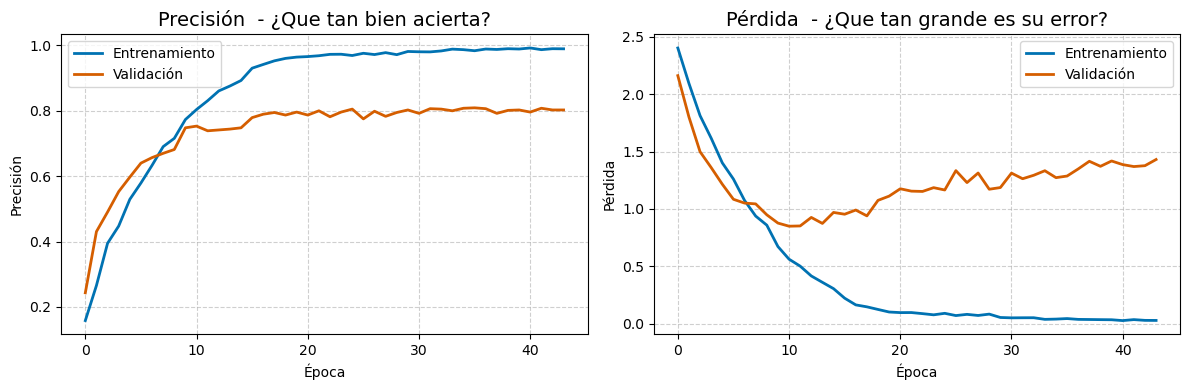

In [7]:
# PASO 7: RESULTADOS (gráficas, matriz, ejemplos bien/mal clasificados)

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) # crea un espacio para graficos (1 fila, 2 columnas) y selecciona la 1 columna
plt.plot(history.history['accuracy'], label='Entrenamiento', color='#0072B2', linewidth=2)  # Grafica la precision en entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='#D55E00', linewidth=2) # Grafica la precision en validacion 
plt.title('Precisión  - ¿Que tan bien acierta?', fontsize=14)
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # muestra en la leyenda quien es entrenamiento y quien validacion

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='#0072B2', linewidth=2)
plt.plot(history.history['val_loss'], label='Validación', color='#D55E00', linewidth=2)
plt.title('Pérdida  - ¿Que tan grande es su error?', fontsize=14)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() # añade margenes a las graficas
plt.show()

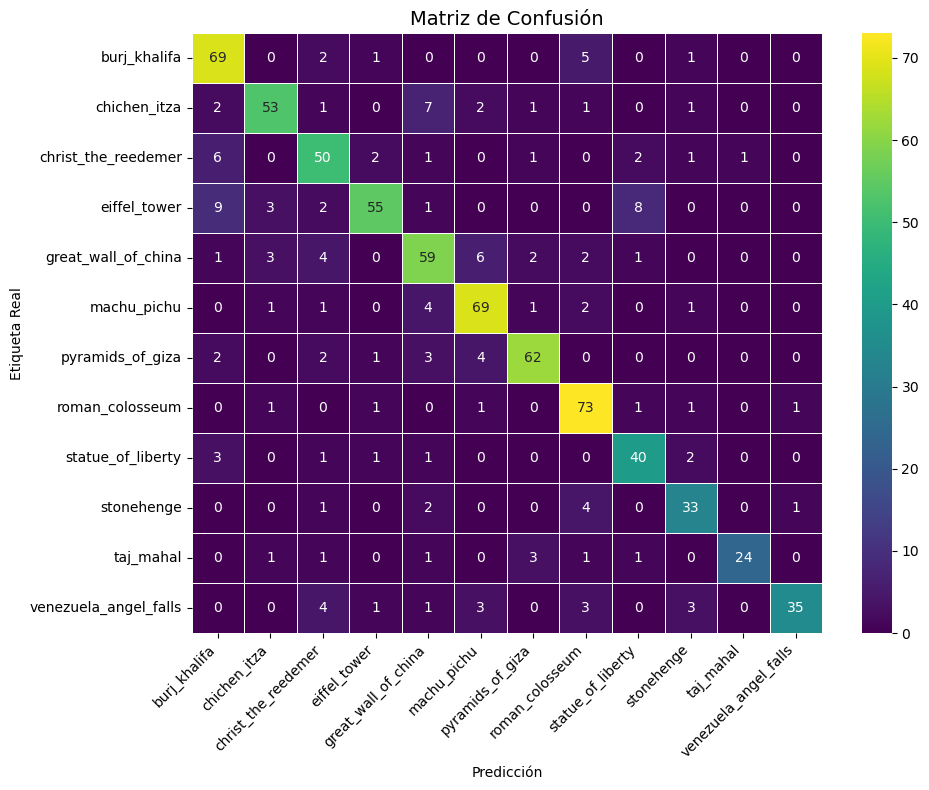

In [13]:
# --- Matriz de confusión ---

val_predictions = model.predict(val_ds, verbose=0) # Obtener predicciones del modelo sobre el conjunto de validación.
y_pred = np.argmax(val_predictions, axis=1)        # Convertir las probabilidades en la clase predicha (índice con mayor probabilidad).

y_true = np.concatenate([y for x, y in val_ds], axis=0)  # Extraer las etiquetas reales del dataset de validación.
y_true = np.argmax(y_true, axis=1)                       # Convertir etiquetas reales one-hot a índices de clase.

# Construir la matriz de confusión comparando etiquetas reales vs predicciones.
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

# Graficar la matriz como un heatmap:
#    - xticklabels/yticklabels: nombres de las clases
#    - annot=True: mostrar valores dentro de cada celda
#    - cmap='viridis': mapa de colores
#    - linewidths/linecolor: separar visualmente las celdas
sns.heatmap(
    cm,
    xticklabels=nombres_clases,
    yticklabels=nombres_clases,
    annot=True,
    fmt='d',
    cmap='viridis',
    linewidths=0.5,
    linecolor='white'
)

# Configuración estética del gráfico.
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.xticks(rotation=45, ha='right')   # rotar etiquetas del eje X para mejor lectura
plt.yticks(rotation=0)                # mantener etiquetas del eje Y horizontales
plt.tight_layout()                    # ajustar distribución para evitar recortes

plt.show()

In [14]:
# --- Reporte de Clasificación (Precision, Recall y F1-score) ---

from sklearn.metrics import classification_report

print("\n📊 Reporte de Clasificación (Precision, Recall, F1-score):")

# - Precisión (precision): qué tan exactas son las predicciones positivas.
# - Sensibilidad o exhaustividad (recall): qué tanto recupera de los casos reales.
# - F1-score: equilibrio entre precisión y recall.

report = classification_report(
    y_true,                         # etiquetas reales del dataset.
    y_pred,                         # etiquetas predichas por el modelo.
    target_names=nombres_clases,    # nombres legibles de cada clase.
    zero_division=0,                # evita errores cuando alguna clase no tiene predicciones.
    output_dict=False               # devuelve el reporte en formato de texto legible.
)

print(report)


📊 Reporte de Clasificación (Precision, Recall, F1-score):
                       precision    recall  f1-score   support

         burj_khalifa       0.75      0.88      0.81        78
         chichen_itza       0.85      0.78      0.82        68
  christ_the_reedemer       0.72      0.78      0.75        64
         eiffel_tower       0.89      0.71      0.79        78
  great_wall_of_china       0.74      0.76      0.75        78
          machu_pichu       0.81      0.87      0.84        79
     pyramids_of_giza       0.89      0.84      0.86        74
      roman_colosseum       0.80      0.92      0.86        79
    statue_of_liberty       0.75      0.83      0.79        48
           stonehenge       0.77      0.80      0.79        41
            taj_mahal       0.96      0.75      0.84        32
venezuela_angel_falls       0.95      0.70      0.80        50

             accuracy                           0.81       769
            macro avg       0.82      0.80      0.81     

C:\Users\CYS\AppData\Local\Temp\ipykernel_41744\4209478666.py:52: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


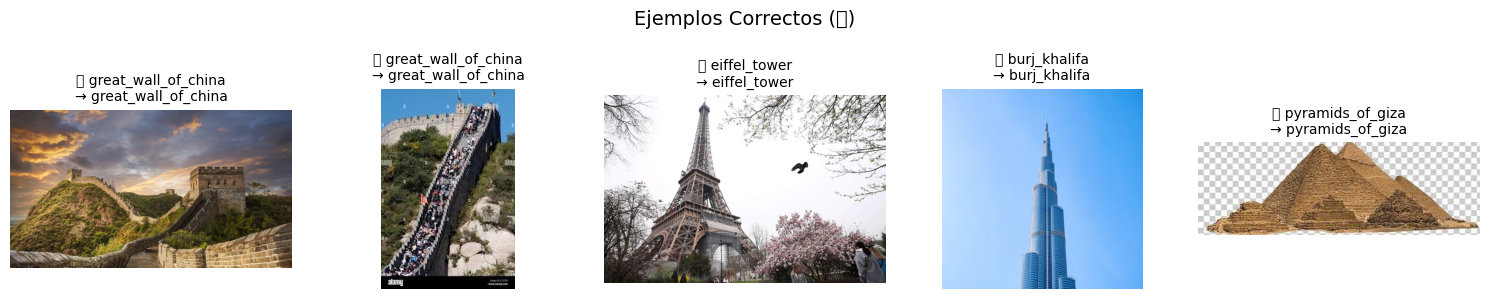

C:\Users\CYS\AppData\Local\Temp\ipykernel_41744\4209478666.py:52: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


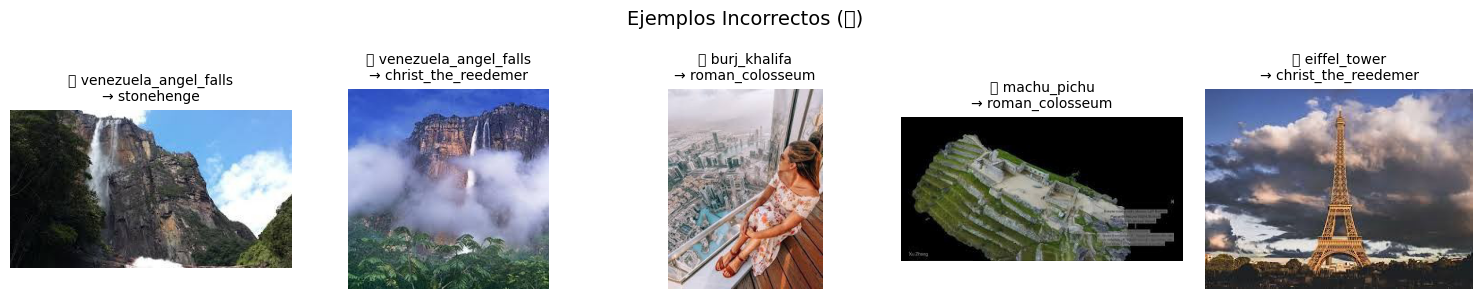

In [15]:
# --- Ejemplos bien y mal clasificados ---

# Rutas completas de las imágenes del conjunto de validación.
val_paths = val_df['ruta_imagen'].values  

# Índices donde el modelo acierta y donde falla.
# Se comparan las etiquetas reales (y_true) con las predicciones (y_pred).
correct_indices = np.where(y_true == y_pred)[0]
incorrect_indices = np.where(y_true != y_pred)[0]

# Selección de hasta cinco ejemplos para cada caso.
# Si la cantidad disponible es menor, se toman todos los existentes.
correct_idx = correct_indices[:5] if len(correct_indices) >= 5 else correct_indices
incorrect_idx = incorrect_indices[:5] if len(incorrect_indices) >= 5 else incorrect_indices

def plot_examples(indices, title, is_correct=True):
    """
    Muestra una fila de imágenes clasificadas por el modelo,
    indicando si fueron predichas correctamente o incorrectamente.

    Parámetros:
        indices (array): índices de las imágenes dentro del dataset de validación.
        title (str): título general del gráfico.
        is_correct (bool): indica si las imágenes corresponden a predicciones correctas.
    """
    
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        # Carga de la imagen original desde su ruta.
        path = val_paths[idx]
        img = Image.open(path)

        # Obtención del nombre de la clase real y la clase predicha.
        pred = nombres_clases[y_pred[idx]]
        real = nombres_clases[y_true[idx]]

        # Representación gráfica de la imagen.
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)

        # Título del subplot indicando el resultado.
        # Se utilizan íconos visuales para mejorar interpretación (✓ o ✗).
        if is_correct:
            plt.title(f"✅ {real}\n→ {pred}", fontsize=10)
        else:
            plt.title(f"❌ {real}\n→ {pred}", fontsize=10)

        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualización de ejemplos correctamente e incorrectamente clasificados.
plot_examples(correct_idx, "Ejemplos Correctos (✅)", is_correct=True)
plot_examples(incorrect_idx, "Ejemplos Incorrectos (❌)", is_correct=False)


## Conclusiones

Este proyecto tuvo como objetivo desarrollar una Red Neuronal Convolucional (CNN) para la clasificación de imágenes de las *12 Maravillas del Mundo*, cumpliendo con los requisitos pedagógicos del curso *Fundamentos de Análisis y Cálculo Numérico*. A continuación, se resumen los hallazgos y aprendizajes clave:

### Principales hallazgos
- El modelo CNN logró una **precisión de validación del 80.88%** (época 36), lo cual representa un desempeño sólido considerando las limitaciones computacionales (entrenamiento en CPU) y la naturaleza desafiante del problema (12 clases visuales con alta similitud, como *chichen_itza* vs *great_wall_of_china*).
- La **conversión forzada a RGB** fue crítica para evitar el estancamiento inicial (~6% de precisión), demostrando la importancia del preprocesamiento riguroso en visión por computadora.
- El uso de **data augmentation** (flips, brillo, contraste, saturación y matiz) ayudó a mejorar la generalización y reducir el sobreajuste, tal como lo evidencian las curvas de entrenamiento estables y el `EarlyStopping` activado solo tras 36 épocas.

### Limitaciones del modelo
- **Sin GPU ni transfer learning**, el modelo no puede alcanzar el 95% de precisión que un sistema industrial sí lograría (por ejemplo, con MobileNetV2 o EfficientNet). Esto es coherente con la literatura: modelos entrenados *from scratch* en CPU tienen un límite práctico en torno al 80–85% para datasets multiclase complejos.
- Algunas clases con mejor desempeño fueron roman_colosseum (F1 = 0.86), machu_pichu (0.87) y pyramids_of_giza (0.84), mientras que taj_mahal (0.74) y statue_of_liberty (0.73) presentaron mayor confusión, atribuible a menor cantidad de ejemplos y variabilidad en ángulos/escala.

### Mejoras futuras
- ✅ **Transfer learning**: Usar una red preentrenada (ej. `tf.keras.applications.MobileNetV2`) como base incrementaría significativamente la precisión (esperado: >90%).
- ✅ **Aumentar resolución**: Cambiar de 128×128 a 160×160 capturaría más detalles arquitectónicos.
- ✅ **Ensamble de modelos**: Combinar múltiples CNN ligeras podría mejorar robustez sin requerir GPU.

En síntesis, el proyecto cumplió con todos los objetivos técnicos y pedagógicos: se exploró, limpió, modeló y evaluó un dataset real con rigor, y se obtuvieron resultados interpretables y justificables desde el punto de vista teórico y práctico.